# Проект: классификация

In [79]:
import pandas as pd
import numpy as np

# Импорт библиотек для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Импорт библиотек для кодирования и масштабиования данных
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Импорт библиотек для построения моделей машинного обучения и оценки качества построенных моделей
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 

# Импорт библиотек для построения ансамблей моделей машинного обучения
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# Импорт библиотек для разбиения данных и отбора признаков
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Импорт библиотек для подбора гиперпараметров моделей машинного обучения
from sklearn.model_selection import GridSearchCV
import optuna

import warnings
warnings.filterwarnings('ignore')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [6]:
# Загрузка исходной базы данных
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [7]:
# Общая информация о базе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [117]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum().sort_values(ascending=False).head(5)

balance     25
age          0
day          0
poutcome     0
previous     0
dtype: int64

В признаке 'balance' содержатся пропуски. Необходима обработка пропусков. 

### Задание 2

In [13]:
# есть ли в признаках job и education пропущенные значения? Возможно, они обозначены каким-то специальным словом?
display(df['job'].unique())
display(df['education'].unique())

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

В признаке 'job' и 'education' содержатся пропуски (unknown). Необходима обработка пропусков. 

### Задание 3

In [11]:
# Преобразование признака balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', '').replace(' ', '').replace(',00', '.')).astype('float')
display(f"Среднее значение признака balance составляет: {round(df['balance'].mean(), 3)}")

'Среднее значение признака balance составляет: 1529.129'

### Задание 4

In [15]:
# Обработка пропусков в признаке balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
display(f"Среднее значение признака balance после обработки пропусков составляет: {round(df['balance'].mean(), 3)}")

'Среднее значение признака balance после обработки пропусков составляет: 1526.936'

### Задание 5

In [16]:
# Обработка пропусков категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown'else x)

In [17]:
# Ответ на вопрос на платформе
display(round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(), 3))

1598.883

### Задание 6

In [18]:
# Удаление выбросов признака 'balance' по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x <= lower_bound) | (x >= upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    bounds = (lower_bound, upper_bound)
    
    return outliers, cleaned, bounds


outliers, cleaned, bounds = outliers_iqr(df, 'balance')

print(f'Границы доверительного интервала по методу Тьюки: {bounds[0], bounds[1]}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Границы доверительного интервала по методу Тьюки: (-2241.0, 4063.0)
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     53.676398
yes    46.323602
Name: deposit, dtype: float64

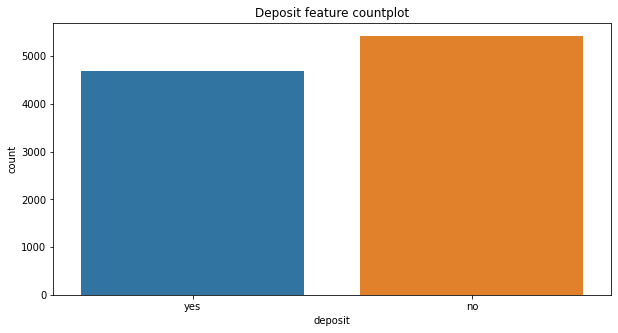

In [21]:
# Иллюстрация соотношения классов в данных на предмет несбалансированности, проиллюстрируйте результат
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(cleaned['deposit']);
ax.set_title('Deposit feature countplot')
display(cleaned['deposit'].value_counts(normalize=True) * 100)

Соотношение классов выглядит достаточно сбалансированным, сильного дисбаланса не наблюдается.

### Задание 2

In [22]:
# Расчет описательной статистики для количественных признаков
display(cleaned.describe())

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


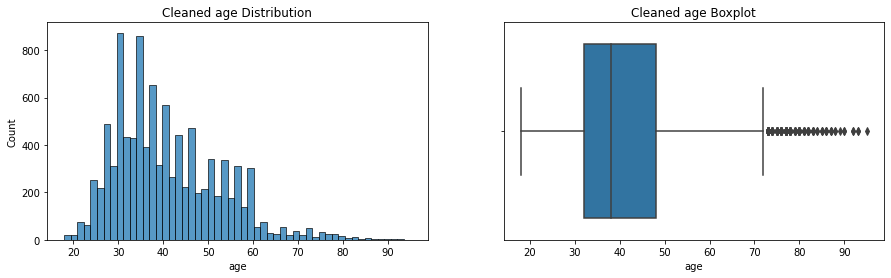

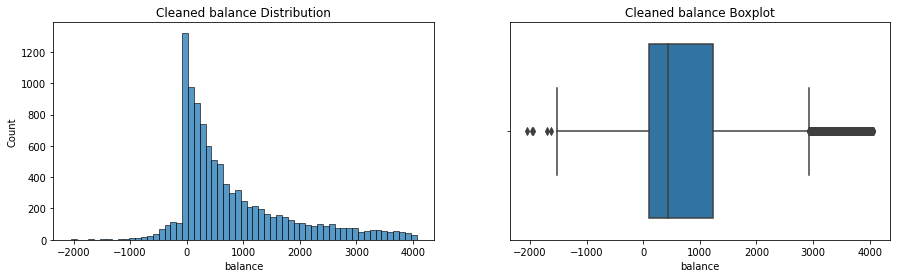

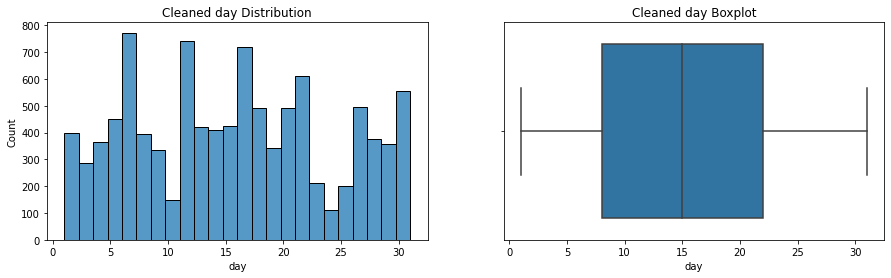

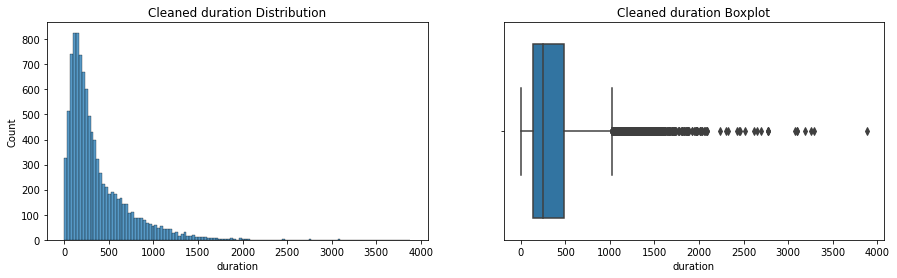

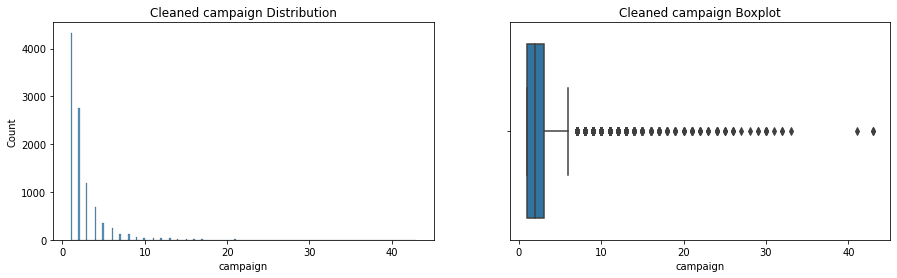

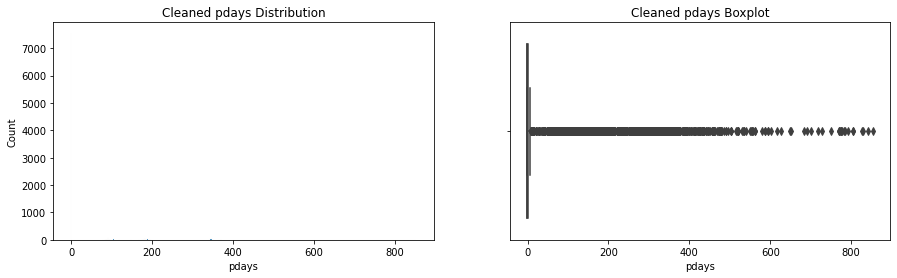

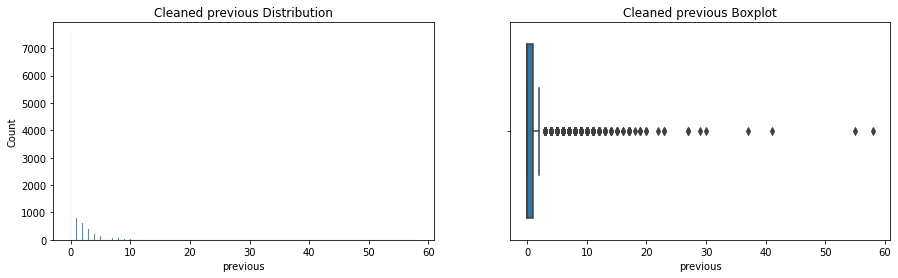

In [23]:
# Иллюстрация распределения количественных признаков
col_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for col in col_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=cleaned, x=col, ax=axes[0]);
    histplot.set_title(f'Cleaned {col} Distribution');
    boxplot = sns.boxplot(data=cleaned, x=col, ax=axes[1]);
    boxplot.set_title(f'Cleaned {col} Boxplot');

### Задание 3

In [24]:
# Расчет описательной статистики для категориальных признаков
cleaned.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


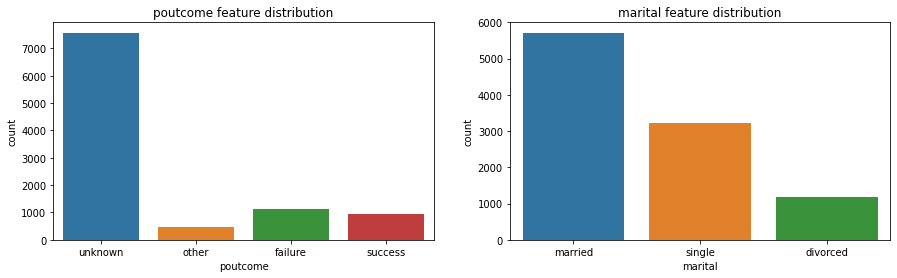

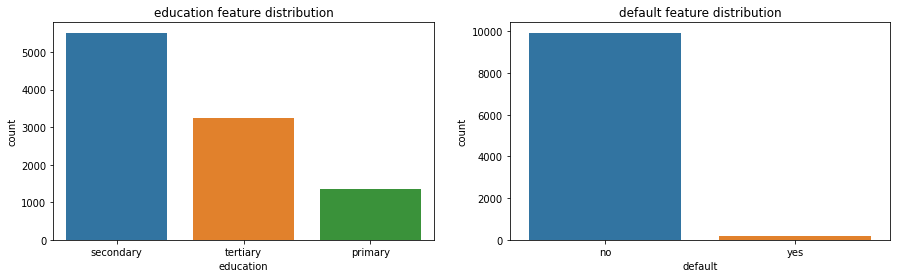

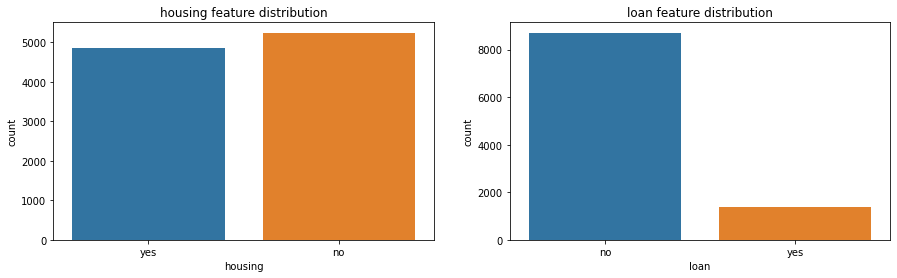

In [25]:
# Иллюстрация распределения категориальных признаков
cat_features = [['poutcome', 'marital'], ['education', 'default'], ['housing', 'loan']]

for cat in cat_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    sns.countplot(data=cleaned, x=cat[0], ax=axes[0])
    axes[0].set_title(f'{cat[0]} feature distribution');
    sns.countplot(data=cleaned, x=cat[1], ax=axes[1])
    axes[1].set_title(f'{cat[1]} feature distribution');

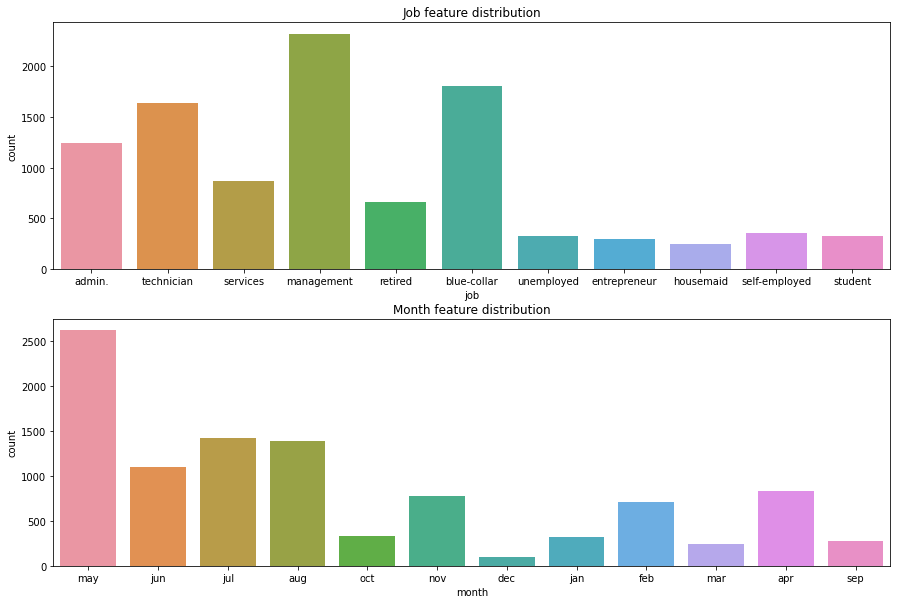

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
sns.countplot(data=cleaned, x='job', ax=axes[0]);
axes[0].set_title('Job feature distribution');
sns.countplot(data=cleaned, x='month', ax=axes[1]);
axes[1].set_title('Month feature distribution');

### Задание 4

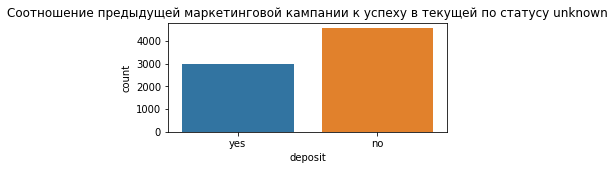

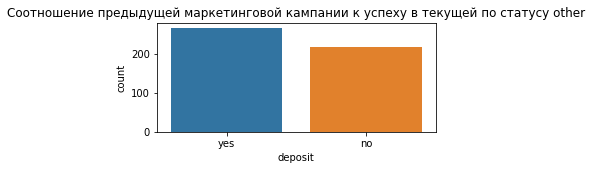

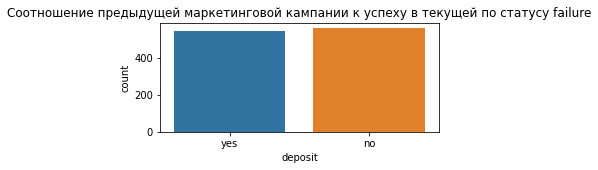

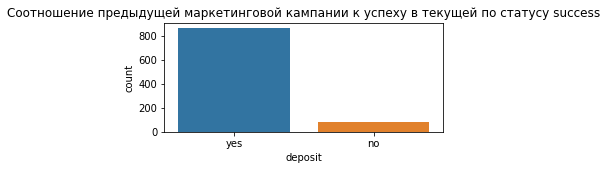

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
poutcome_list = list(cleaned['poutcome'].unique())
poutcome_list
for status in poutcome_list:
    fig = plt.figure(figsize=(5, 2))
    ax = sns.countplot(cleaned[cleaned['poutcome'] == status]['deposit'])
    ax.set_title(f'Соотношение предыдущей маркетинговой кампании к успеху в текущей по статусу {status}')

### Задание 5

In [28]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month_list = list(cleaned['month'].unique())

month_stat = {}
for month in month_list:
    month_stat.update(
        {month: 
        round(cleaned[(cleaned['month'] == month) & (cleaned['deposit'] == 'no')].shape[0] / cleaned[cleaned['month'] == month].shape[0], 2)        
        }
)

display(month_stat)

{'may': 0.68,
 'jun': 0.55,
 'jul': 0.59,
 'aug': 0.56,
 'oct': 0.19,
 'nov': 0.58,
 'dec': 0.1,
 'jan': 0.61,
 'feb': 0.46,
 'mar': 0.1,
 'apr': 0.38,
 'sep': 0.17}

### Задание 6

In [29]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_groupping(age):
    if age < 30:
        return '<30'
    elif (age >= 30 and age < 40):
        return '30-40'
    elif (age >= 40 and age < 50):
        return '40-50'
    elif (age >= 50 and age < 60):
        return '50-60'
    else:
        return '60+'

cleaned['age_group'] = cleaned['age'].apply(age_groupping)
cleaned['deposit_'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
age_grouped = cleaned.groupby(['age_group'])['deposit_'].mean()
display(age_grouped)
marital_grouped = cleaned.groupby(['marital'])['deposit_'].mean()
display(marital_grouped)
education_grouped = cleaned.groupby(['education'])['deposit_'].mean()
display(education_grouped)

age_group
30-40    0.433224
40-50    0.393787
50-60    0.405079
60+      0.759571
<30      0.591753
Name: deposit_, dtype: float64

marital
divorced    0.469839
married     0.422047
single      0.534080
Name: deposit_, dtype: float64

education
primary      0.383247
secondary    0.444263
tertiary     0.528867
Name: deposit_, dtype: float64

### Задание 7

<Figure size 720x360 with 0 Axes>

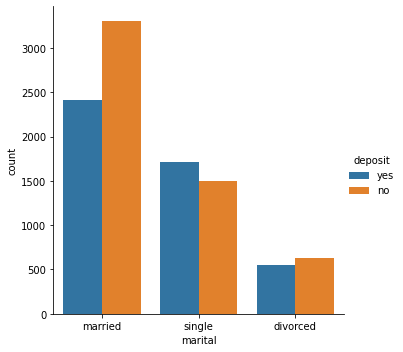

In [33]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(10, 5))
catplot = sns.catplot(
    data=cleaned,
    x='marital',
    hue='deposit',
    kind='count'
);


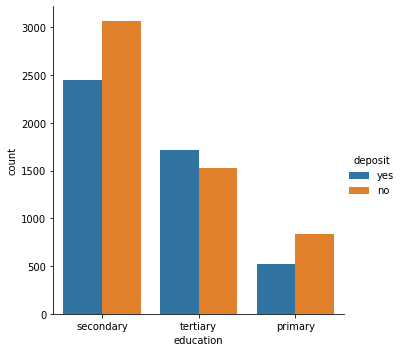

In [34]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
catplot = sns.catplot(
    data=cleaned,
    x='education',
    hue='deposit',
    kind='count'
);

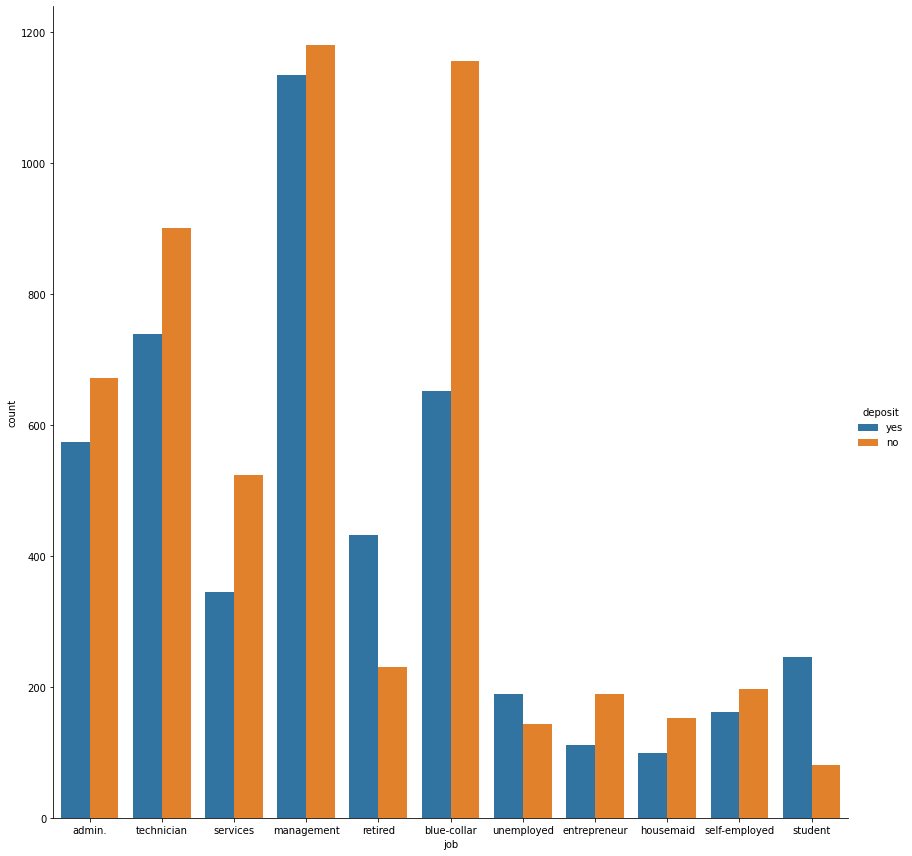

In [35]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
catplot = sns.catplot(
    data=cleaned,
    x='job',
    hue='deposit',
    kind='count',
    height=12,
    aspect=1
);


### Задание 8

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


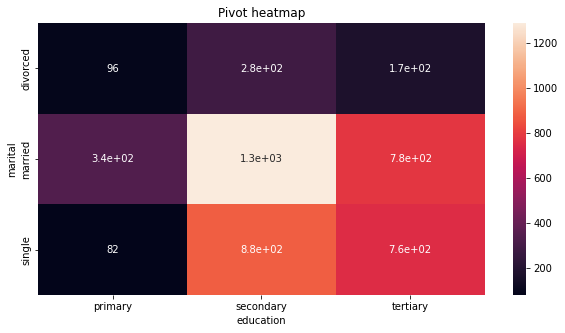

In [41]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# если рассматривать тех, кто открыл депозит
positive = cleaned[cleaned['deposit'] == 'yes']
negative = cleaned[cleaned['deposit'] == 'no']

pivot_pos = pd.pivot_table(positive, values='deposit', index=['marital'],
                    columns=['education'], aggfunc=np.count_nonzero)

display(pivot_pos)

fig = plt.figure(figsize=(10, 5))
hm = sns.heatmap(pivot_pos, cbar=True, annot=True);
hm.set_title('Pivot heatmap');

In [42]:
cleaned = cleaned.drop(['deposit_'], axis=1)

## Часть 3: преобразование данных

### Задание 1

In [43]:
# Кодирование признака education
le = LabelEncoder()
data_bin = pd.Series(le.fit_transform(cleaned['education']), name='education_')
encoded = pd.concat([cleaned.reset_index(drop=True), data_bin.reset_index(drop=True)], axis=1)

encoded = encoded.drop('education', axis=1)
encoded['education'] = encoded['education_']
encoded = encoded.drop('education_', axis=1)

In [44]:
# Кодирование признака age_group
le = LabelEncoder()
data_bin = pd.Series(le.fit_transform(cleaned['age_group']), name='age_group_')
encoded = pd.concat([cleaned.reset_index(drop=True), data_bin.reset_index(drop=True)], axis=1)

encoded = encoded.drop('age_group', axis=1)
encoded['age_group'] = encoded['age_group_']
encoded = encoded.drop('age_group_', axis=1)

### Задание 2

In [45]:
# Преобразование бинарных признаков
encoded['deposit'] = encoded['deposit'].apply(lambda x: 1 if x=='yes' else 0)
encoded['default'] = encoded['default'].apply(lambda x: 1 if x=='yes' else 0)
encoded['housing'] = encoded['housing'].apply(lambda x: 1 if x=='yes' else 0)
encoded['loan'] = encoded['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [46]:
# Ответ на задание на платформе
display(encoded['default'].mean()+encoded['housing'].mean()+encoded['loan'].mean())

0.6354280059376547

### Задание 3

In [47]:
# Создание дамми-переменных
job_dummies = pd.get_dummies(encoded['job'], prefix=['job'])
marital_dummies = pd.get_dummies(encoded['marital'], prefix=['marital'])
contact_dummies = pd.get_dummies(encoded['contact'], prefix=['contact'])
month_dummies = pd.get_dummies(encoded['month'], prefix=['month'])
poutcome_dummies = pd.get_dummies(encoded['poutcome'], prefix=['poutcome'])

encoded_dummies = pd.concat([encoded, job_dummies, marital_dummies, contact_dummies, month_dummies, poutcome_dummies], axis=1)

### Задание 4

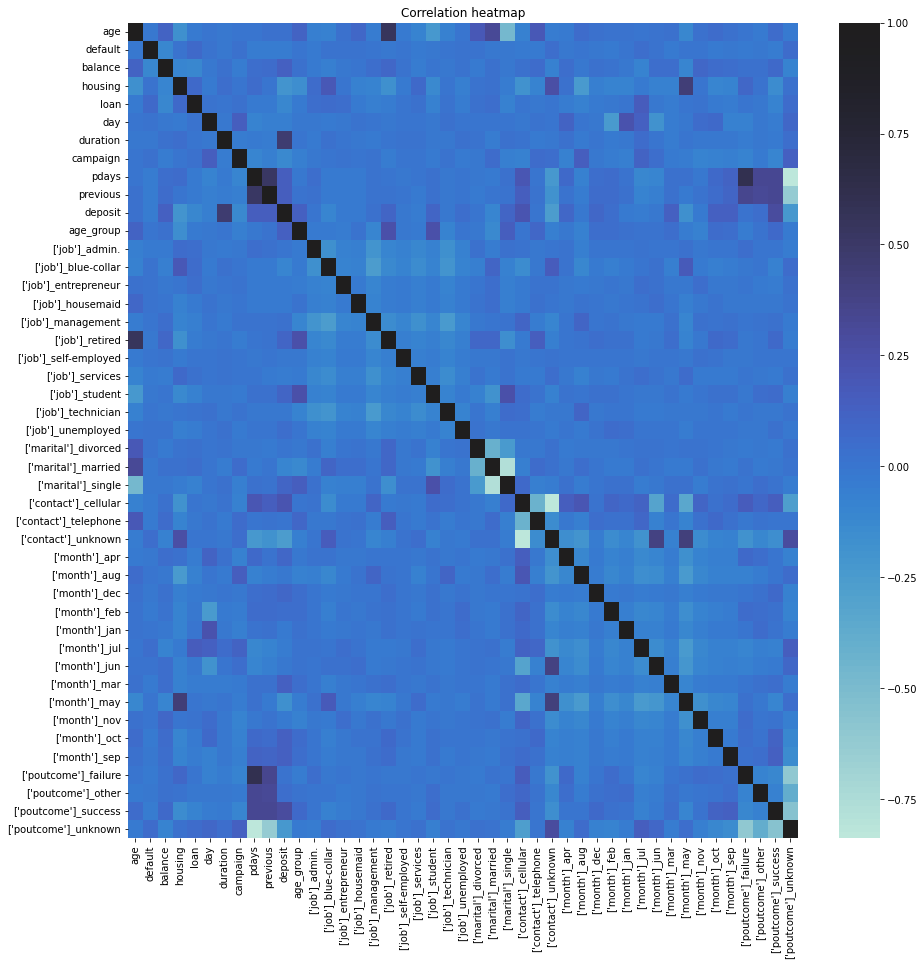

In [51]:
# Построение коллинеарной матрицы
fig = plt.figure(figsize=(15, 15))
corr_map = sns.heatmap(encoded_dummies.corr(), center=True);
corr_map.set_title('Correlation heatmap');

In [52]:
# Вывод признаков с коэффициентом корреляции выше заданного
for i, row in encoded_dummies.corr().iterrows():
    if row['deposit'] >= 0.2:
        if i != 'deposit':
            print(f"Признак '{i}' имеет коэффициент корреляции с целевым признаком: {round(row['deposit'], 3)}")

Признак 'duration' имеет коэффициент корреляции с целевым признаком: 0.458
Признак '['contact']_cellular' имеет коэффициент корреляции с целевым признаком: 0.224
Признак '['poutcome']_success' имеет коэффициент корреляции с целевым признаком: 0.288


Мультиколлинеарные признаки отсутствуют

### Задание 5

In [53]:
# Формирование данных для обучения и целевого признака
X = encoded_dummies.drop(['deposit'], axis=1)
y = encoded_dummies['deposit']

# Разбиение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

display(X_train.shape)
display(X_test.shape)

(6770, 50)

(3335, 50)

In [54]:
# Ответ на задание на платформе
display(f'Среднее значение целового признака на тестовой выборке: {round(y_test.mean(), 2)}')

'Среднее значение целового признака на тестовой выборке: 0.46'

### Задание 6

In [55]:
# Удаление оставшихся категориальных признаков
object_columns = [s for s in X_train.columns if X_train[s].dtypes == 'object']

X_train.drop(object_columns, axis = 1, inplace=True)
X_test.drop(object_columns, axis = 1, inplace=True)

In [64]:
# Отбор с помощью SelectKBest 15 наиболее подходящих признаков
KBest = SelectKBest(score_func = f_classif, k=15)
KBest.fit(X_train, y_train)

X_train_kbest = KBest.transform(X_train)
X_test_kbest = KBest.transform(X_test)
X_train_kbest = (pd.DataFrame(X_train_kbest, columns=KBest.get_feature_names_out(X_train.columns)))
X_test_kbest = (pd.DataFrame(X_test_kbest, columns=KBest.get_feature_names_out(X_test.columns)))

display(f'Оставшиеся для моделирования признаки :{KBest.get_feature_names_out(X_train.columns)}')

'Оставшиеся для моделирования признаки :[\'balance\' \'housing\' \'duration\' \'campaign\' \'pdays\' \'previous\' \'age_group\'\n "[\'contact\']_cellular" "[\'contact\']_unknown" "[\'month\']_mar"\n "[\'month\']_may" "[\'month\']_oct" "[\'month\']_sep" "[\'poutcome\']_success"\n "[\'poutcome\']_unknown"]'

### Задание 7

In [66]:
# Вывод описательной статистики для оставшихся признаков
X_train_kbest.describe().T

,count,mean,std,min,25%,50%,75%,max
balance,6770.0,805.087297,995.709709,-2049.0,92.0,442.0,1227.00,4063.0
housing,6770.0,0.479321,0.499609,0.0,0.0,0.0,1.00,1.0
duration,6770.0,371.134417,350.628525,2.0,138.0,255.0,486.75,3881.0
campaign,6770.0,2.516544,2.720295,1.0,1.0,2.0,3.00,43.0
pdays,6770.0,50.921123,108.993529,-1.0,-1.0,-1.0,-1.00,854.0
previous,6770.0,0.803988,2.220418,0.0,0.0,0.0,0.00,58.0
age_group,6770.0,1.326736,1.416680,0.0,0.0,1.0,2.00,4.0
['contact']_cellular,6770.0,0.721713,0.448188,0.0,0.0,1.0,1.00,1.0
['contact']_unknown,6770.0,0.216100,0.411614,0.0,0.0,0.0,0.00,1.0
['month']_mar,6770.0,0.023338,0.150987,0.0,0.0,0.0,0.00,1.0


In [67]:
# Нормализация данных с помощью MinMaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train_kbest)

X_train_scaled = scaler.transform(X_train_kbest)
X_test_scaled = scaler.transform(X_test_kbest)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_kbest.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_kbest.columns)

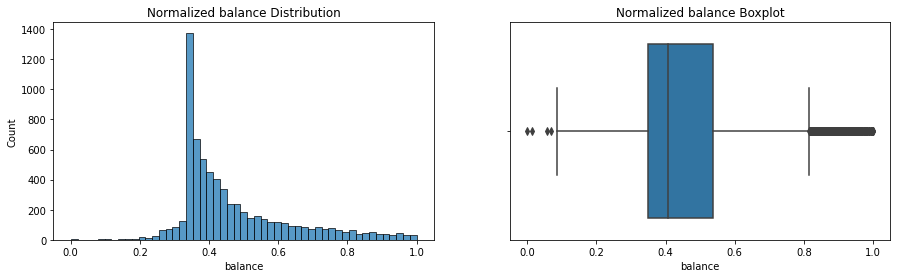

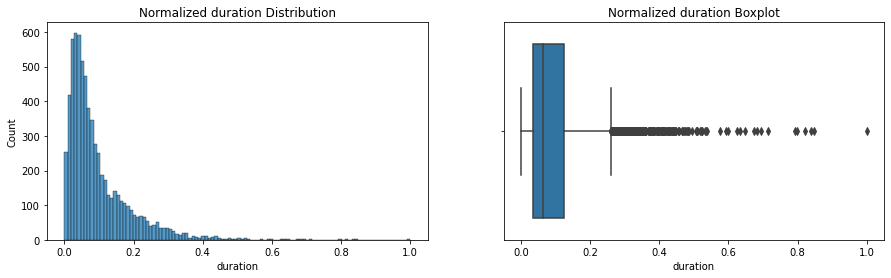

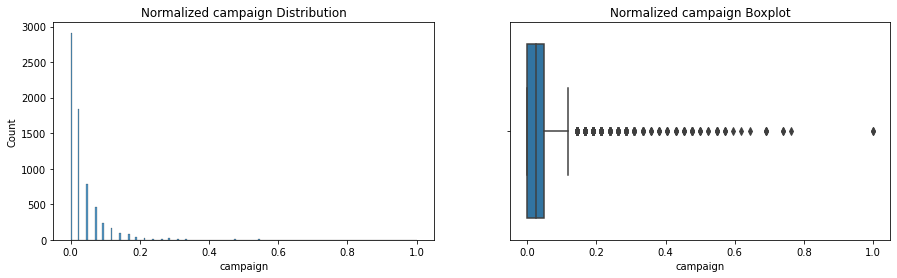

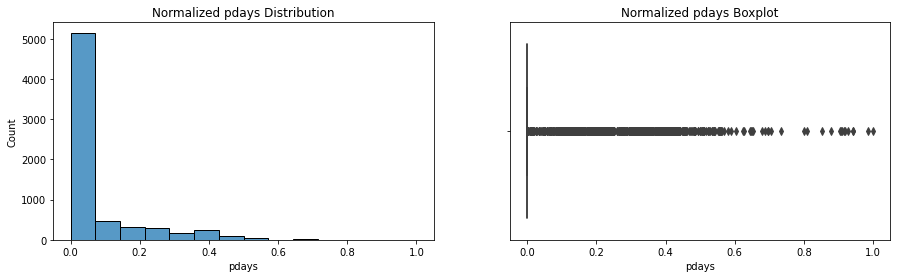

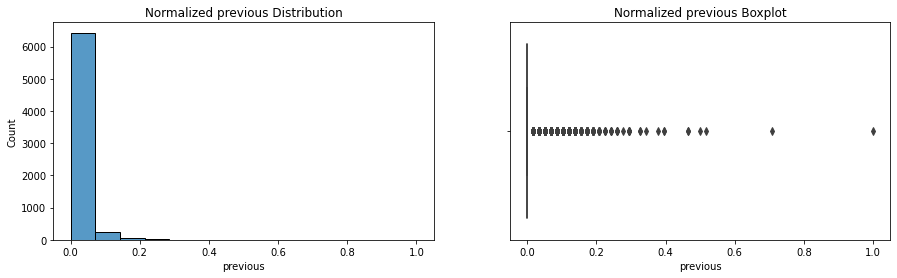

In [71]:
# Иллюстрация распределения количественных признаков после нормализации
col_features = ['balance', 'duration', 'campaign', 'pdays', 'previous']

for col in col_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=X_train_scaled, x=col, ax=axes[0]);
    histplot.set_title(f'Normalized {col} Distribution');
    boxplot = sns.boxplot(data=X_train_scaled, x=col, ax=axes[1]);
    boxplot.set_title(f'Normalized {col} Boxplot');

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [72]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', # алгоритм оптимизации
    random_state=42,
    max_iter=1000
)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [73]:
#Делаем предсказание для тренировочной выборки
y_train_log_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_log_pred))
#Делаем предсказание для тестовой выборки
y_test_log_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_log_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



Метрика F1-score для модели логистической регрессии на тестовой выборке соствляет: 0.78

### Задание 2

In [74]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Обучение модели
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [75]:
#Делаем предсказание для тренировочной выборки
y_train_dt_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_dt_pred))
#Делаем предсказание для тестовой выборки
y_test_dt_pred = dt.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Модель решающего дерева на стандартных параметрах переобучена. Необходимо подобрать оптимальные гиперпараметры.

### Задание 3

In [76]:
# Подбор оптимальных параметров с помощью gridsearch
param_grid = {
    'max_depth': list(np.linspace(1, 10, dtype=int)),
    'min_samples_split': list(np.linspace(2, 10, dtype=int))
}

grid_search_tree = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

grid_search_tree.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3,
                                       3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
                                       6, 6, ...],
                         'min_samples_split': [2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
                                               3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5,
                                               5, 5, 5, 6, 6, 6, 6, 6, ...]})

In [77]:
# Ответ на задание на платформе
print("accuracy на тренировочном наборе: {:.2f}".format(grid_search_tree.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))

#Делаем предсказание для тренировочной выборки
y_train_gdt_pred = grid_search_tree.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_gdt_pred))
#Делаем предсказание для тестовой выборки
y_test_gdt_pred = grid_search_tree.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_gdt_pred))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

accuracy на тренировочном наборе: 0.85
accuracy на тестовом наборе: 0.81
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3634
           1       0.82      0.87      0.85      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1790
           1       0.78      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Наилучшие значения гиперпараметров: {'max_depth': 9, 'min_samples_split': 2}


Метрика F1-score для модели дерева решений на тестовой выборке соствляет: 0.80

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [80]:
# Создание модели случайного леса
rf = RandomForestClassifier(
    criterion='gini',
    n_estimators=100,
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [81]:
#Делаем предсказание для тренировочной выборки
y_train_rf_pred = rf.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_rf_pred))
#Делаем предсказание для тестовой выборки
y_test_rf_pred = rf.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_rf_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Метрика F1-score для модели случайного леса на тестовой выборке соствляет: 0.82

### Задание 2

In [82]:
# Создание модели для классификации на основе градиентного бустинга
gb = GradientBoostingClassifier(
    loss='deviance', # функция потерь
    learning_rate=0.05, # темп обучения
    n_estimators=300, # число деревьев
    max_depth=5, # максимальная глубина дерева
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел
)

gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, loss='deviance', max_depth=5,
                           min_samples_leaf=5, n_estimators=300,
                           random_state=42)

In [83]:
#Делаем предсказание для тренировочной выборки
y_train_gb_pred = gb.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_gb_pred))
#Делаем предсказание для тестовой выборки
y_test_gb_pred = gb.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_gb_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Метрика F1-score для модели градиентного бустинга на тестовой выборке соствляет: 0.82
Однако в сравнении с модельню случайного леса разница между показателями на тестовой выборке и тренировочной для модели градиентного бустинга оказалась больше, в результате чего можно сделать вывод, что модель случайного леса обучена более подходящим образом.

### Задание 3

In [84]:
# Объединение построенных моделей с помощью стекинга
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', log_reg) # Модель логистической регрессии
    ('dt', dt) # Модель дерева решений
    ('gb', gb) # Модель градиентного бустинга
]

#Создаем объект класса стекинг
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', # алгоритм оптимизации
                                                    random_state=42,
                                                    max_iter=1000
    )
)

#Обучаем модель
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           loss='deviance',
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [102]:
#Делаем предсказание для тренировочной выборки
y_train_stack_pred = stack.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_stack_pred))
#Делаем предсказание для тестовой выборки
y_test_stack_pred = stack.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_stack_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Метрика F1-score для модели стекинга на тестовой выборке соствляет: 0.82

### Задание 4

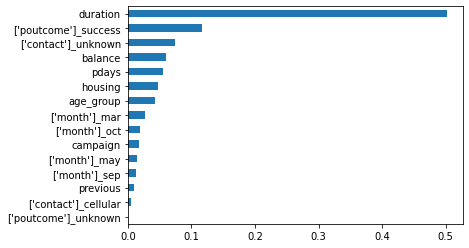

In [86]:
# Визуализация важности признаков в модели градиентного бустинга
imp = pd.Series(gb.feature_importances_, index=X_train_scaled.columns)
imp.sort_values(inplace = True)
imp.plot(kind = 'barh');

### Задание 5

In [104]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 3, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

In [105]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

[I 2022-08-08 17:31:55,343] A new study created in memory with name: RandomForestClassifier
[I 2022-08-08 17:31:56,371] Trial 0 finished with value: 0.844647931796653 and parameters: {'n_estimators': 173, 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.844647931796653.
[I 2022-08-08 17:31:56,936] Trial 1 finished with value: 0.7615489130434782 and parameters: {'n_estimators': 141, 'max_depth': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.844647931796653.
[I 2022-08-08 17:31:57,786] Trial 2 finished with value: 0.8406940063091481 and parameters: {'n_estimators': 135, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.844647931796653.
[I 2022-08-08 17:31:59,145] Trial 3 finished with value: 0.8778125 and parameters: {'n_estimators': 187, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8778125.
[I 2022-08-08 17:31:59,910] Trial 4 finished with value: 0.8488937705946963 and parameters: {'n_estimators': 121, 'max_

In [106]:
# Рассчитаем точность для тестовой выборки
model = RandomForestClassifier(**study.best_params, random_state=42,)
model.fit(X_train_scaled, y_train)
# Делаем предсказание для тренировочной выборки
y_train_opt_pred = model.predict(X_train_scaled)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_opt_pred))
# Делаем предсказание для тренировочной выборки
y_test_opt_pred = model.predict(X_test_scaled)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_opt_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3634
           1       0.91      0.94      0.93      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



Метрика F1-score для модели логистической регрессии на тестовой выборке соствляет: 0.82
Однако значения метрик на тренировочной выборке имеют высокие показатели и достаточно сильно отличаются от показателей метрик на тестовой выборке. Подбор параметров с помощью фреймворка optuna в данном случае избыточно подстроился под обучающую выборку.

In [108]:
# Итоговое сравнение метрика качества построенных моделей (F1-score)
print(f'Метрика F1-score для модели логистической регрессии: {round(metrics.f1_score(y_test, y_test_log_pred), 3)}')
print(f'Метрика F1-score для модели дерева решений: {round(metrics.f1_score(y_test, y_test_gdt_pred), 3)}')
print(f'Метрика F1-score для модели случайного леса (с заданными параметрами): {round(metrics.f1_score(y_test, y_test_rf_pred), 3)}')
print(f'Метрика F1-score для модели градиентного бустинга: {round(metrics.f1_score(y_test, y_test_gb_pred), 3)}')
print(f'Метрика F1-score для модели стекинга: {round(metrics.f1_score(y_test, y_test_stack_pred), 3)}')
print(f'Метрика F1-score для модели случайного леса (с параметрами, подобранными с помощью фреймворка Optuna): {round(metrics.f1_score(y_test, y_test_opt_pred), 3)}')

Метрика F1-score для модели логистической регрессии: 0.777
Метрика F1-score для модели дерева решений: 0.8
Метрика F1-score для модели случайного леса (с заданными параметрами): 0.819
Метрика F1-score для модели градиентного бустинга: 0.817
Метрика F1-score для модели стекинга: 0.807
Метрика F1-score для модели случайного леса (с параметрами, подобранными с помощью фреймворка Optuna): 0.817


По результатам анализа полученных показателей метрики F1-score для построенных моделей, можно сделать вывод о том, что наилучший показатель контролируемой метрики имеет модель случайного леса (0.819). 

Резюме: наилучшей моделью является модель случайного леса (с заданными параметрами)